In [408]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pickle

In [490]:
data=pd.read_csv("trimmed_data_v3.csv",index_col=0)

#data=data.fillna(0)
data=data.dropna()

print(sum(np.isnan(data.vol)),sum(data.vol==0))
data.head()

0 1852


,Date,sec_id,fut_ret,vol,X1,X3,X4,X6,X7,X1_norm,X3_norm,X4_norm,X6_norm,X7_norm,log_vol
0,0.0,0.000000,0.037521,0.000563,0.002766,0.000000,0.0,0.0,0.000000e+00,2.128681,0.095161,-0.109858,0.180895,-0.080587,0.269877
1,0.0,0.000502,0.005565,0.000805,-0.000461,0.000000,0.0,0.0,0.000000e+00,-0.674305,0.095161,-0.109858,0.180895,-0.080587,0.879423
2,0.0,0.001005,-0.008732,0.000584,0.001580,-0.000464,0.0,0.0,3.921761e-13,1.098681,-5.279814,-0.109858,0.180895,-0.080587,0.331473
3,0.0,0.001507,0.000695,0.000326,0.000243,0.000000,0.0,0.0,0.000000e+00,-0.062127,0.095161,-0.109858,0.180895,-0.080587,-0.598987
4,0.0,0.002009,-0.002755,0.000461,0.000259,0.000000,0.0,0.0,0.000000e+00,-0.048683,0.095161,-0.109858,0.180895,-0.080587,-0.057603


In [522]:
# oos
data=pd.read_csv('data_oos.csv',index_col=0)

In [491]:
vol=data.vol
vol=vol[vol!=0]
print(sum(np.isnan(vol)))
vol_min=min(vol)
print(vol_min)

0
0.00016147414862643927


In [492]:
def fun(srs):
    if srs.vol==0:
        srs.vol=vol_min
    return srs

data=data.apply(fun,axis=1)
print(sum(data.vol==0))

0


In [88]:
278000+845

278845

In [112]:
len(RE1_train_pred)

277938

In [493]:
data['ret_vol']=data.fut_ret/data.vol

#data_train=data.iloc[:278845]
#data_test=data.iloc[278845:]

data_train=data.iloc[:277938]
data_test=data.iloc[277938:]

In [7]:
'''
mid_ran=(np.max(np.array(data.ret_vol))+np.min(np.array(data.ret_vol)))/2
half_ran=(np.max(np.array(data.ret_vol))-np.min(np.array(data.ret_vol)))/2
data['ret_vol_scale']=(data['ret_vol']-mid_ran)/half_ran
'''

"\nmid_ran=(np.max(np.array(data.ret_vol))+np.min(np.array(data.ret_vol)))/2\nhalf_ran=(np.max(np.array(data.ret_vol))-np.min(np.array(data.ret_vol)))/2\ndata['ret_vol_scale']=(data['ret_vol']-mid_ran)/half_ran\n"

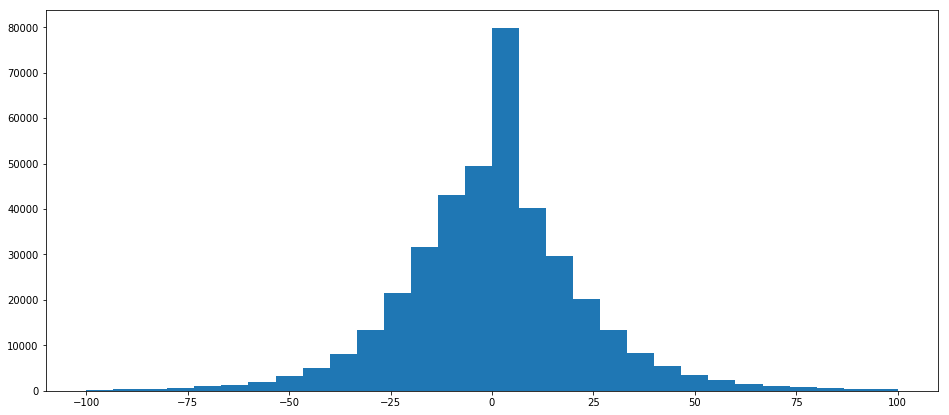

In [213]:
plt.figure(figsize=(16,7))
plt.hist(np.array(data['ret_vol']),range=(-100,100),bins=30)
plt.show()

In [494]:
X_train=np.array(data_train[['sec_id','X1_norm','X3']])
#X=np.array(data[['sec_id','X1','X3','X4','X6','X7']])
#X=np.array(data[['sec_id','vol','X1','X']])
y_train=np.array(data_train['ret_vol'])
Z_train=np.array(data_train[['fut_ret','vol']])

train_all=(X_train,y_train)

print(np.shape(X_train),np.shape(y_train),np.shape(Z_train))

X_test=np.array(data_test[['sec_id','X1_norm','X3']])
y_test=np.array(data_test['ret_vol'])
Z_test=np.array(data_test[['fut_ret','vol']])

test_all=(X_test,y_test)

# test:cv:train=2:2:6
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25)
print(np.shape(X_train))

Z_train=X_train[:,-2:]
Z_test=X_test[:,-2:]
Z_cv=X_cv[:,-2:]

X_train=X_train[:,:-2]
X_test=X_test[:,:-2]
X_cv=X_cv[:,:-2]
print(np.shape(X_train))

train_all=(X_train,y_train)
cv_all=(X_cv,y_cv)
'''

(277938, 3) (277938,) (277938, 2)


'\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)\nX_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25)\nprint(np.shape(X_train))\n\nZ_train=X_train[:,-2:]\nZ_test=X_test[:,-2:]\nZ_cv=X_cv[:,-2:]\n\nX_train=X_train[:,:-2]\nX_test=X_test[:,:-2]\nX_cv=X_cv[:,:-2]\nprint(np.shape(X_train))\n\ntrain_all=(X_train,y_train)\ncv_all=(X_cv,y_cv)\n'

In [495]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
        
        
def NN(data_set, test_set, nodes=[16], epoch=1000, learning_rate=1e-3, is_drop=False, l2_reg=0, is_leaky=False,
        is_batch=False):
    x = torch.tensor(data_set[0], dtype=torch.float32)
    y = torch.tensor(data_set[1][:, np.newaxis], dtype=torch.float32)
    
    # model initialize
    out_size = 1
    F = x.shape[1]
    layer_num = len(nodes)

    # add layers
    model = torch.nn.Sequential()
    model.add_module("linear 0", torch.nn.Linear(F, nodes[0]))
    if is_batch:
        model.add_module("batch 0",torch.nn.BatchNorm1d(nodes[0]))   
    if is_drop:
        model.add_module("drop 0", torch.nn.Dropout(0.5))
    model.add_module("relu 0", torch.nn.ReLU() if not is_leaky else torch.nn.PReLU())
    

    for i in range(layer_num-1):
        model.add_module("linear "+str(i+1),torch.nn.Linear(nodes[i], nodes[i+1]))
        if is_batch:
            model.add_module("batch "+str(i+1),torch.nn.BatchNorm1d(nodes[i+1]))
        if is_drop:
            model.add_module("drop "+str(i+1), torch.nn.Dropout(0.5))
        model.add_module("relu "+str(i+1), torch.nn.ReLU() if not is_leaky else torch.nn.PReLU())
        
    
    # HE initial
    model.apply(init_weights)
    
    #output layer
    model.add_module("linear "+str(layer_num),
                     torch.nn.Linear(nodes[-1], out_size))

    # loss
    loss_fn = torch.nn.MSELoss()    
    #loss_fn=torch.nn.L1Loss()
    
    # optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=l2_reg)

    # training
    loss_history = []
    loss_old=float('inf')
    loss_new=0
    count=0

    for t in range(epoch):
        y_pred = model(x)

        loss_new = loss_fn(y_pred, y)
        
        if abs(loss_old-loss_new)<1e-9:
            count=count+1
        else:
            count=0
            
        if count>30:
            print("converge epoch: ",t)
            break
            
        loss_old = loss_new
        
        #if loss<0.000296:
        #    print("converge epoch: ",t)
        #    break

        if t % 1000== 999:
            print("epoch ", t+1, ", loss is ", loss_new.item())
        #loss_history.append(loss.item())

        optimizer.zero_grad()

        loss_new.backward()

        optimizer.step()

    # plot loss evolution
    #plt.figure(figsize=(14, 7))
    #plt.plot(range(len(loss_history)), loss_history)
    #plt.xlabel("epoch")
    #plt.ylabel("loss")
    #plt.show()

    # testing
    x_test = torch.tensor(test_set[0], dtype=torch.float32)
    y_test = torch.tensor(test_set[1][:, np.newaxis], dtype=torch.float32)
    
    y_in_pred = model(x)
    y_out_pred = model(x_test)
    
    err_in = loss_fn(y_in_pred, y).item()
    err_out = loss_fn(y_out_pred, y_test).item()
    
       
    y=data_set[1]
    y_test=test_set[1]
    y_in_pred=torch.Tensor.numpy(y_in_pred.data)
    y_in_pred.reshape(y_in_pred.shape[0])
    y_out_pred=torch.Tensor.numpy(y_out_pred.data)
    y_out_pred.reshape(y_out_pred.shape[0])
    
    r2_in = r2_score(y, y_in_pred)
    r2_out = r2_score(y_test, y_out_pred)

    #print("\nin-sample error: ", err_in)
    #print("out-of-sample error: ", err_out)
    #print("in-sample r2: ", r2_in)
    #print("out-of-sample r2: ", r2_out)

    return (model,r2_out,err_in)

In [496]:
# for test
def test_r2(model,X = X_test,y = y_test, Z = Z_test, plot=True):   
    y_pred=model(torch.tensor(Ｘ, dtype=torch.float32))
    y_pred=torch.Tensor.numpy(y_pred.data)
    y_pred=y_pred.reshape(y_pred.shape[0])
    # reverse back to none scale
    #y_pred=y_pred*half_ran+mid_ran
    
    y_pred=y_pred*Z[:,1]
    if plot:
        plt.figure(figsize=(16,7))
        plt.subplot(1, 2, 1)
        plt.hist(y_pred,range=(-0.1,0.1),bins=30)
        plt.subplot(1, 2, 2)
        plt.hist(Z[:,0],range=(-0.1,0.1),bins=30)
        plt.show()
    r2 = r2_score(Z[:,0], y_pred)
    return (r2,y_pred)


def MDA(model,X = X_test,y = y_test, Z = Z_test):
    feature_num=X.shape[1]
    r2_origin = test_r2(model,X,y,Z,plot=False)[0]
    print("origin: ",r2_origin)
    for i in range(feature_num):
        r2_new_lst=[]
        for j in range(10):
            X_new=X.copy()
            np.random.shuffle(X_new[:,i])
            r2_new=test_r2(model,X_new,y,Z,plot=False)[0]
            r2_new_lst.append(r2_new)
        is_valid=" *"
        if np.mean(r2_new_lst)>r2_origin:
            is_valid=" "
        if abs(np.mean(r2_new_lst)-r2_origin)/abs(r2_origin)<0.01:
            is_valid=" "
        print("suffle feature ",i,": ",np.mean(r2_new_lst),is_valid)

## Experiment

In [360]:
grid_history=[]

In [369]:
nodes_list=[
    [4]
]          

t=1 
for nodes in nodes_list:
    for epoch in [1000]:
        for lr in [1]:
            for isdrop in [False]:
                for l2reg in [1e-1]:
                    for isleaky in [True]:
                        for isbatch in [True]:
                            model,r2,mse=NN(train_all,test_all,nodes, epoch, lr, isdrop, l2reg, isleaky, isbatch)
                            grid_history.append([r2,model,mse,nodes, epoch, lr, isdrop, l2reg, isleaky, isbatch])
                            print(t,": ",r2,"  ",mse,"  ",nodes, isdrop, l2reg, isleaky, isbatch)
                            t=t+1



epoch  1000 , loss is  866.0393676757812
1 :  0.0008585964824109338    866.0421142578125    [4] False 0.1 True True


[866.0421142578125, [4], 1000, 1, False, 0.1, True, True]
0.0008585964824109338


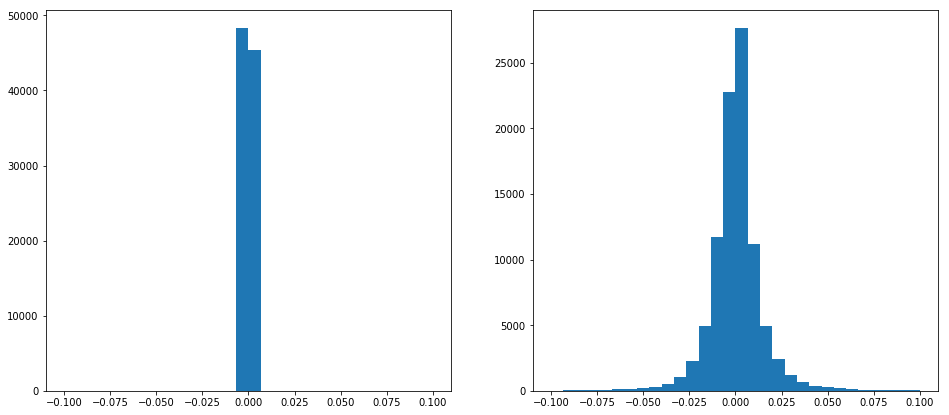

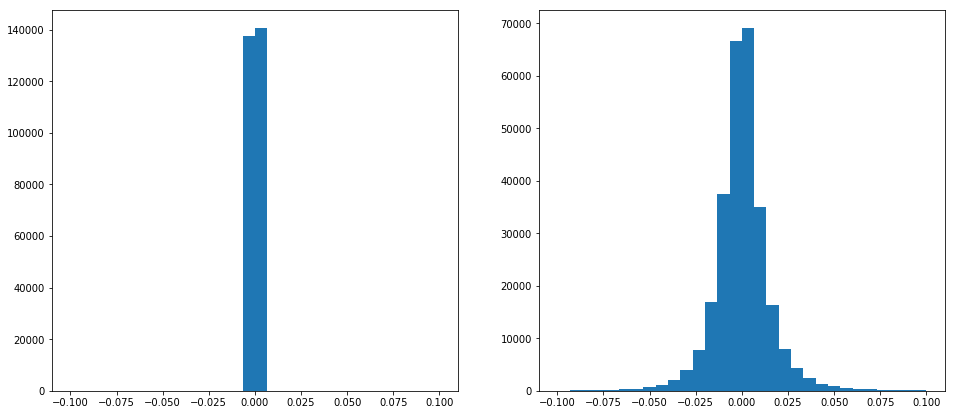

0.0010982058270998518 , in sample:  0.0007653655899381162 



In [370]:
#for i in range(1,len(grid_history)+1):
i=1
print(grid_history[-i][2:])
print(grid_history[-i][0])
print(test_r2(grid_history[-i][1])[0],", in sample: ",test_r2(grid_history[-i][1],X_train,y_train,Z_train)[0],'\n')



In [220]:
MDA(grid_history[-i][1])

origin:  0.001284031642796002
suffle feature  0 :  0.0012648182724249502  *
suffle feature  1 :  -0.0006359406896633502  *
suffle feature  2 :  0.0012840316704292199  


In [221]:
print(grid_history)

[[0.0009219038890067033, Sequential(
  (linear 0): Linear(in_features=3, out_features=4, bias=True)
  (batch 0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu 0): PReLU(num_parameters=1)
  (linear 1): Linear(in_features=4, out_features=1, bias=True)
), 808.7374877929688, [4], 1000, 1, False, 0.1, True, True]]


In [371]:
torch.save(grid_history[-1][1],'NN')

In [372]:
model = torch.load('NN')
model.eval()

Sequential(
  (linear 0): Linear(in_features=3, out_features=4, bias=True)
  (batch 0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu 0): PReLU(num_parameters=1)
  (linear 1): Linear(in_features=4, out_features=1, bias=True)
)

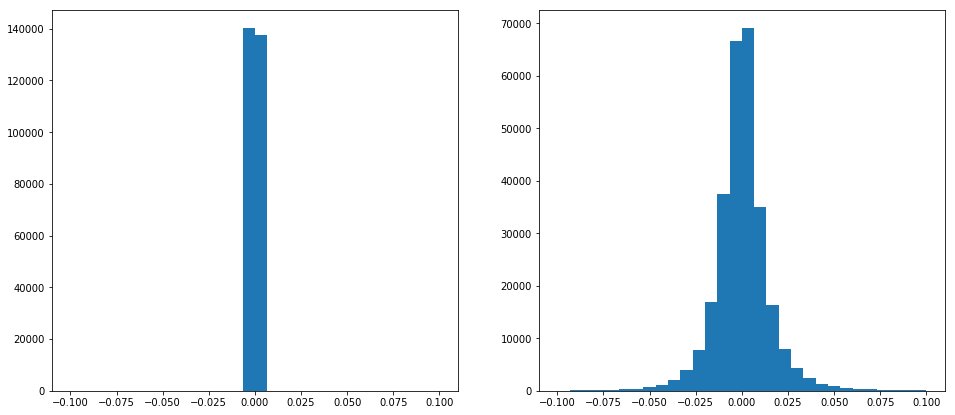

0.000741270878089062


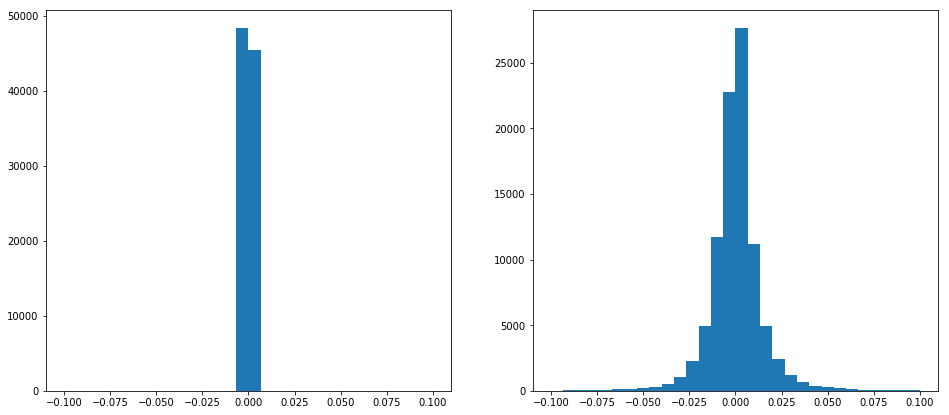

0.0011030937347910053


In [373]:
r2_NN_1,NN_train_pred = test_r2(model,X_train,y_train,Z_train)
print(r2_NN_1)
r2_NN_2,NN_test_pred = test_r2(model)
print(r2_NN_2)

## Aggregate

### NN

In [436]:
data=pd.read_csv('data_oos_v1.csv',index_col=0)
data_2=data[np.isnan(data.vol)]
data_1=data[~np.isnan(data.vol)]

In [437]:
model = torch.load('NN')
model.eval()

X_train=np.array(data_1[['sec_id','X1_norm','X3']])
y_train=np.array(data_1['vol'])
Z_train=np.array(data_1[['vol','vol']])

r2_oos_1,NN_oos_pred = test_r2(model,X_train,y_train,Z_train,False)

In [394]:
len(data_2)+len(data_1)

101643

In [497]:
model = torch.load('NN')
model.eval()

r2_NN_1,NN_train_pred = test_r2(model,X_train,y_train,Z_train,False)
r2_NN_2,NN_test_pred = test_r2(model,plot=False)
print(np.shape(NN_train_pred),np.shape(NN_test_pred))
print(r2_NN_1,r2_NN_2)

(277938,) (93714,)
0.000741270878089062 0.0011030937347910053


### Light GBM

In [498]:
import pickle
with open ('Light_GBM_data', 'rb') as fp:
    result_copy = pickle.load(fp)
GBM_train_pred,r2_GBM_1,GBM_test_pred,r2_GBM_2=result_copy
GBM_train_pred=np.array(GBM_train_pred)
GBM_test_pred=np.array(GBM_test_pred)
print(np.shape(GBM_train_pred),np.shape(GBM_test_pred))
print(r2_GBM_1,r2_GBM_2)

(277938,) (93714,)
0.0016084083573307817 0.0005731492141478611


### Regression

In [499]:
with open ('Regression_data', 'rb') as fp:
    result_copy_2 = pickle.load(fp)
RE1_train_pred,r2_RE1_1,RE1_test_pred,r2_RE1_2,  RE2_train_pred,r2_RE2_1,RE2_test_pred,r2_RE2_2=result_copy_2

RE2_train_pred=np.reshape(RE2_train_pred,np.shape(RE2_train_pred)[1])
RE2_test_pred=np.reshape(RE2_test_pred,np.shape(RE2_test_pred)[1])

RE1_train_pred=np.array(RE1_train_pred)
RE1_test_pred=np.array(RE1_test_pred)
RE2_train_pred=np.array(RE2_train_pred)
RE2_test_pred=np.array(RE2_test_pred)


print(np.shape(RE1_train_pred),np.shape(RE1_test_pred))
print(r2_RE1_1,r2_RE1_2)
print(np.shape(RE2_train_pred),np.shape(RE2_test_pred))
print(r2_RE2_1,r2_RE2_2)

(277938,) (93714,)
0.0009318110379955558 0.001069811660696196
(277938,) (93714,)
0.0009696237406092711 0.001042140045127038


### Forest

In [500]:
with open ('forest_data1_b_final', 'rb') as fp:
    result_copy_3 = pickle.load(fp)
RF1_train_pred,r2_RF1_1,RF1_test_pred,r2_RF1_2=result_copy_3

with open ('forest_data3_b_final', 'rb') as fp:
    result_copy_4 = pickle.load(fp)
RF2_train_pred,r2_RF2_1,RF2_test_pred,r2_RF2_2=result_copy_4

r2_RF1_1=r2_RF1_1[0]
r2_RF1_2=r2_RF1_2[0]
r2_RF2_1=r2_RF2_1[0]
r2_RF2_2=r2_RF2_2[0]

print(np.shape(RF1_train_pred),np.shape(RF1_test_pred))
print(r2_RF1_1,r2_RF1_2)
print(np.shape(RF2_train_pred),np.shape(RF2_test_pred))
print(r2_RF2_1,r2_RF2_2)

(277938,) (93714,)
0.0025575351225033405 0.0012484703051111046
(277938,) (93714,)
0.002066069758914879 0.0010272692184059018


# OOS

In [501]:
print(np.shape(NN_oos_pred))


with open ('Light_GBM_Data_oos_V3', 'rb') as fp:
    result_copy = pickle.load(fp)
GBM_oos_pred=result_copy
GBM_oos_pred=np.reshape(GBM_oos_pred,np.shape(GBM_oos_pred)[1])
GBM_oos_pred=np.array(GBM_oos_pred)
print(np.shape(GBM_oos_pred))


with open ('Regression_data_oos_V3', 'rb') as fp:
    result_copy_2 = pickle.load(fp)
RE1_oos_pred, RE2_oos_pred=result_copy_2

RE1_oos_pred=np.array(RE1_oos_pred)
RE2_oos_pred=np.array(RE2_oos_pred)

print(np.shape(RE1_oos_pred))
print(np.shape(RE2_oos_pred))


with open ('final_result_1_gooder', 'rb') as fp:
    result_copy_3 = pickle.load(fp)
RF1_oos_pred=result_copy_3

with open ('final_result_3_gooder', 'rb') as fp:
    result_copy_4 = pickle.load(fp)
RF2_oos_pred=result_copy_4

print(np.shape(RF1_oos_pred))
print(np.shape(RF2_oos_pred))


(96251,)
(96251,)
(96251,)
(96251,)
(96251,)
(96251,)


In [442]:
X_oos=np.array([NN_oos_pred,RE1_oos_pred,RE2_oos_pred,GBM_oos_pred,RF1_oos_pred,RF2_oos_pred])
X_oos=X_oos.T
print(np.shape(X_oos))

(96251, 6)


In [443]:
res=ranf.predict(X_oos)

with open('oos_prediction_v2', 'wb') as fp:
    pickle.dump(res, fp)

In [444]:
data_1['prediction']=res

/home/zecophy/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


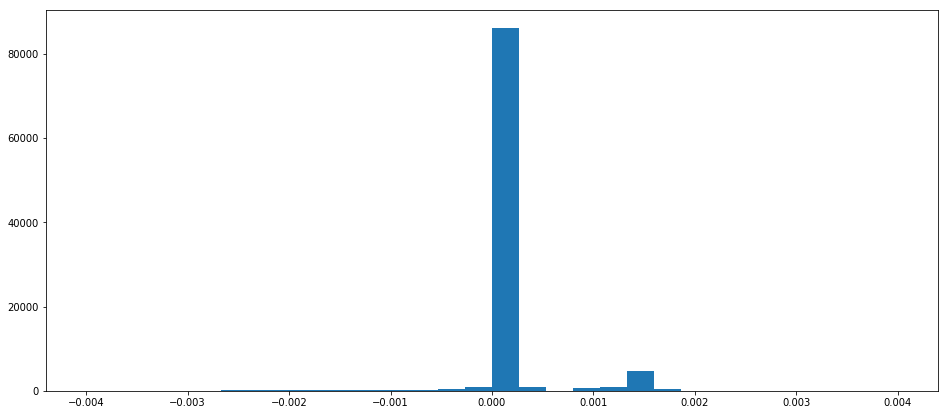

In [445]:
plt.figure(figsize=(16,7))
plt.hist(res,range=(-0.004,0.004),bins=30)
plt.show()

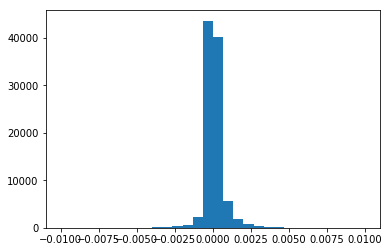

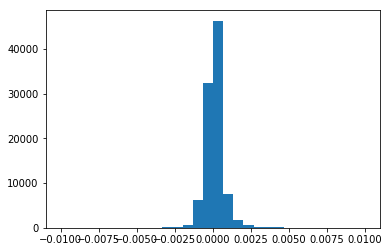

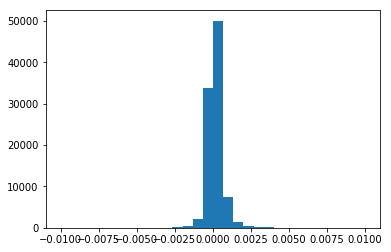

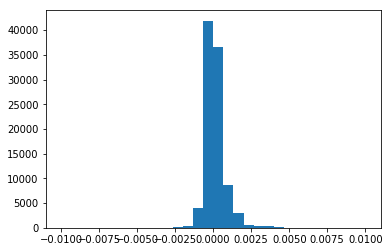

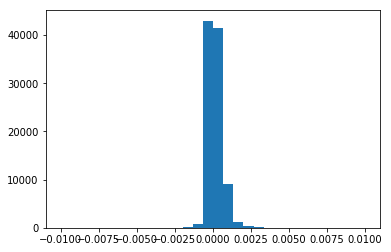

In [446]:
for i in [NN_oos_pred,RE1_oos_pred,RE2_oos_pred,RF1_oos_pred,RF2_oos_pred]:
    plt.hist(i,range=(-0.01,0.01),bins=30)
    plt.show()

In [447]:
d=X_oos
d=pd.DataFrame(d)
corr = d.corr()
corr.style.background_gradient(cmap='binary')

,0,1,2,3,4,5
0,1,0.78463,0.889503,0.637136,0.67996,0.628202
1,0.78463,1,0.944693,0.649958,0.702259,0.657991
2,0.889503,0.944693,1,0.68949,0.720738,0.684102
3,0.637136,0.649958,0.68949,1,0.791801,0.767996
4,0.67996,0.702259,0.720738,0.791801,1,0.946601
5,0.628202,0.657991,0.684102,0.767996,0.946601,1


### Combine Data

In [378]:
dd=[[r2_NN_1,r2_NN_2],[r2_GBM_1,r2_GBM_2],[r2_RE1_1,r2_RE1_2],[r2_RE2_1,r2_RE2_2],[r2_RF1_1,r2_RF1_2],[r2_RF2_1,r2_RF2_2]]

result=pd.DataFrame(data=dd,columns=['train','test'],index=['NN','GBM','Regression1','Regression2','Forest1','Forest2'])

In [379]:
result

,train,test
NN,0.000741,0.001103
GBM,0.001608,0.000573
Regression1,0.000932,0.001070
Regression2,0.000970,0.001042
Forest1,0.002520,0.001384
Forest2,0.003359,0.001026


## Build new data set!

In [502]:
dd=[]

#aa=len(NN_test_pred)
aa=70285
#aa=85270

In [503]:
X_train=np.array([NN_test_pred[:aa],RE1_test_pred[:aa],RE2_test_pred[:aa],GBM_test_pred[:aa],
                  RF1_test_pred[:aa],RF2_test_pred[:aa]])
#X_train=np.array([NN_test_pred[:aa],RE1_test_pred[:aa],RE2_test_pred[:aa],
#                  RF1_test_pred[:aa],RF2_test_pred[:aa]])
X_train=X_train.T
print(np.shape(X_train))
y_train=np.array(data_test['fut_ret'])[:aa]
train=(X_train,y_train)


X_test=np.array([NN_test_pred[aa:],RE1_test_pred[aa:],RE2_test_pred[aa:],GBM_test_pred[aa:],
                 RF1_test_pred[aa:],RF2_test_pred[aa:]])
#X_test=np.array([NN_test_pred[aa:],RE1_test_pred[aa:],RE2_test_pred[aa:],
#                 RF1_test_pred[aa:],RF2_test_pred[aa:]])
X_test=X_test.T
print(np.shape(X_test))
y_test=np.array(data_test['fut_ret'])[aa:]
test=(X_test,y_test)

(70285, 6)
(23429, 6)


In [383]:
dd.append([r2_score(y_train,NN_test_pred[:aa]),r2_score(y_test,NN_test_pred[aa:])])
dd.append([r2_score(y_train,GBM_test_pred[:aa]),r2_score(y_test,GBM_test_pred[aa:])])
dd.append([r2_score(y_train,RE1_test_pred[:aa]),r2_score(y_test,RE1_test_pred[aa:])])
dd.append([r2_score(y_train,RE2_test_pred[:aa]),r2_score(y_test,RE2_test_pred[aa:])])
dd.append([r2_score(y_train,RF1_test_pred[:aa]),r2_score(y_test,RF1_test_pred[aa:])])
dd.append([r2_score(y_train,RF2_test_pred[:aa]),r2_score(y_test,RF2_test_pred[aa:])])

## AGG

In [384]:
d=X_train
d=pd.DataFrame(d)
corr = d.corr()
corr.style.background_gradient(cmap='binary')

,0,1,2,3,4,5
0,1,0.869168,0.901291,0.63839,0.672616,0.580091
1,0.869168,1,0.948424,0.705184,0.735551,0.671929
2,0.901291,0.948424,1,0.685353,0.720101,0.653424
3,0.63839,0.705184,0.685353,1,0.789573,0.712224
4,0.672616,0.735551,0.720101,0.789573,1,0.91553
5,0.580091,0.671929,0.653424,0.712224,0.91553,1


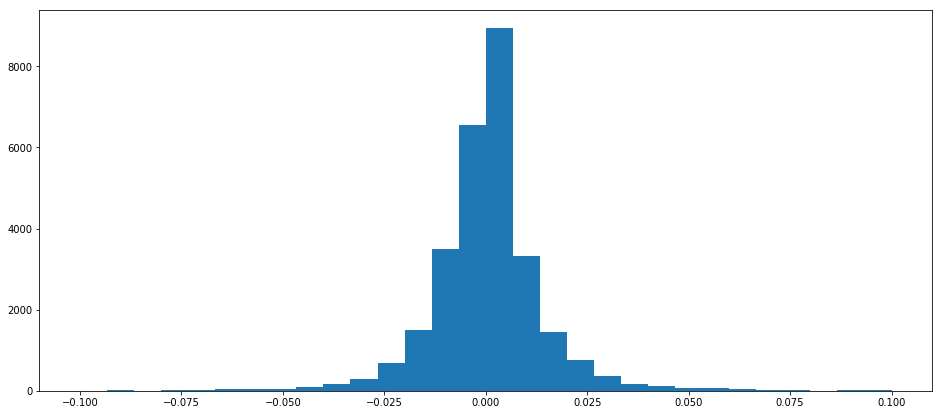

In [349]:
plt.figure(figsize=(16,7))
plt.hist(y_test,range=(-0.1,0.1),bins=30)
plt.show()

for i in [NN_test_pred,RE1_test_pred,RE2_test_pred,GBM_test_pred,RF1_test_pred,RF2_test_pred]:
    plt.hist(i,range=(-0.01,0.01),bins=30)
    plt.show()

### NN

In [257]:
def agg_test(model,plot=True):   
    y_pred=model(torch.tensor(Ｘ_train, dtype=torch.float32))
    y_pred=torch.Tensor.numpy(y_pred.data)
    y_pred_in=y_pred.reshape(y_pred.shape[0])
    r2_in = r2_score(y_train, y_pred_in)
    
    y_pred=model(torch.tensor(Ｘ_test, dtype=torch.float32))
    y_pred=torch.Tensor.numpy(y_pred.data)
    y_pred_out=y_pred.reshape(y_pred.shape[0])
    r2_out = r2_score(y_test, y_pred_out)
    
    print("in: ",r2_in,"  out:",r2_out)
    
    if plot:
        plt.figure(figsize=(16,7))
        plt.subplot(2, 2, 1)
        plt.hist(y_pred_in,range=(-0.1,0.1),bins=30)
        plt.subplot(2, 2, 2)
        plt.hist(y_train,range=(-0.1,0.1),bins=30)
        plt.subplot(2, 2, 3)
        plt.hist(y_pred_out,range=(-0.1,0.1),bins=30)
        plt.subplot(2, 2, 4)
        plt.hist(y_test,range=(-0.1,0.1),bins=30)
        plt.show()
    
    return (r2_in,r2_out,y_pred_in,y_pred_out)

converge epoch:  186
1 :  -3.8929432714995826e-05    0.0002869645832106471    [2] False 0.1 True True
in:  -8.878244848187222e-07   out: -3.8929432714995826e-05


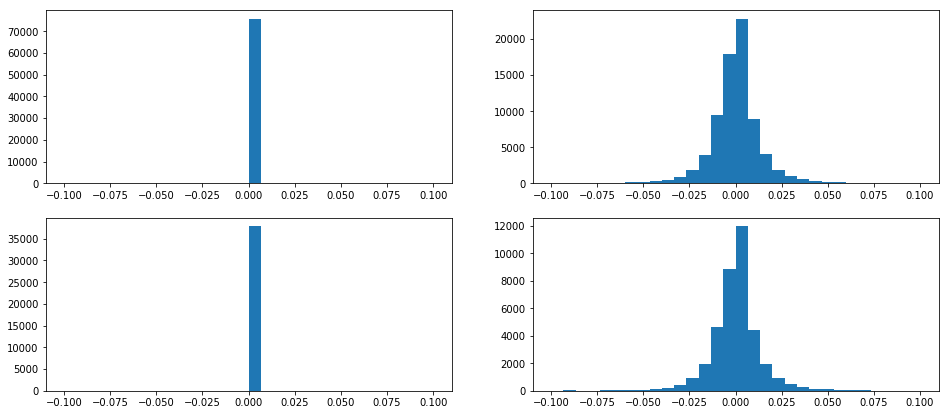

In [258]:
history=[]

nodes_list=[
    [2]
]          

t=1 
for nodes in nodes_list:
    for epoch in [3000]:
        for lr in [0.1]:
            for isdrop in [False]:
                for l2reg in [1e-1]:
                    for isleaky in [True]:
                        for isbatch in [True]:
                            model,r2,mse=NN(train,test,nodes, epoch, lr, isdrop, l2reg, isleaky, isbatch)
                            history.append([r2,model,mse,nodes, epoch, lr, isdrop, l2reg, isleaky, isbatch])
                            print(t,": ",r2,"  ",mse,"  ",nodes, isdrop, l2reg, isleaky, isbatch)
                            t=t+1
                            a,b,c,d=agg_test(model)
                            dd.append([a,b])


### Linear

In [259]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [260]:
linReg = LinearRegression().fit(X_train, y_train)
print('Linear regression in sample R2:', linReg.score(X_train, y_train))
print('Linear regression out sample R2:',linReg.score(X_test, y_test))
print('Coefficients:', linReg.coef_)
dd.append([linReg.score(X_train, y_train),linReg.score(X_test, y_test)])

Linear regression in sample R2: 0.002052586382402688
Linear regression out sample R2: 0.0009614709411364109
Coefficients: [ 0.68351411 -0.34726978  0.61714064  0.12997766  2.00412452 -2.09381185]


In [261]:
LasReg = Lasso(alpha=6e-8).fit(X_train,y_train)
print('Linear regression in sample R2:', LasReg.score(X_train, y_train))
print('Linear regression out sample R2:',LasReg.score(X_test, y_test))
print('Coefficients:', LasReg.coef_)
dd.append([LasReg.score(X_train, y_train),LasReg.score(X_test, y_test)])

Linear regression in sample R2: 0.001772253081511965
Linear regression out sample R2: 0.001211469760859618
Coefficients: [0.76046411 0.         0.         0.         0.50227368 0.        ]


In [262]:
RidReg = Ridge(alpha=1e-2).fit(X_train,y_train)
print('Linear regression in sample R2:', RidReg.score(X_train, y_train))
print('Linear regression out sample R2:',RidReg.score(X_test, y_test))
print('Coefficients:', RidReg.coef_)
dd.append([RidReg.score(X_train, y_train),RidReg.score(X_test, y_test)])

Linear regression in sample R2: 0.0017214684939760307
Linear regression out sample R2: 0.0012318965806769056
Coefficients: [0.42125031 0.12621194 0.23640255 0.12776756 0.4061472  0.03282986]


### Forest

In [263]:
from sklearn.ensemble import RandomForestRegressor

In [504]:
print(len(X_train),len(X_test))

70285 23429


In [506]:
ranf=RandomForestRegressor(n_estimators = 200, max_depth = 3).fit(X_train,y_train)
print('Linear regression in sample R2:', ranf.score(X_train, y_train))
print('Linear regression out sample R2:',ranf.score(X_test, y_test))#dd.append([ranf.score(X_train, y_train),ranf.score(X_test, y_test)])

Linear regression in sample R2: 0.012741941078395436
Linear regression out sample R2: 0.0022345032308235258


In [ ]:
Linear regression in sample R2: 0.01267176162890915
Linear regression out sample R2: 0.0023324774553283856

In [534]:
#[NN_test_pred[:aa],RE1_test_pred[:aa],RE2_test_pred[:aa],GBM_test_pred[:aa],
#                  RF1_test_pred[:aa],RF2_test_pred[:aa]]
ranf.feature_importances_ 

array([0.26931832, 0.1825856 , 0.13878568, 0.08665231, 0.17319282,
       0.14946527])

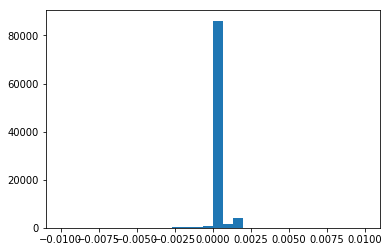

In [434]:
plt.hist(ranf.predict(X_train),range=(-0.01,0.01),bins=30)
plt.show()

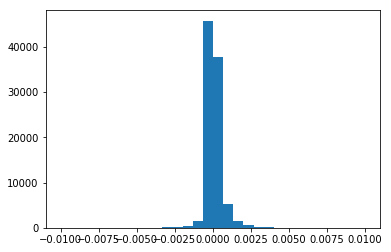

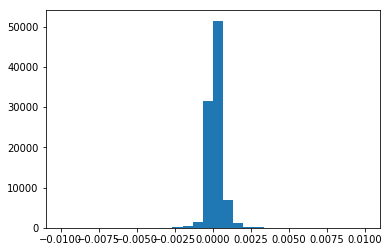

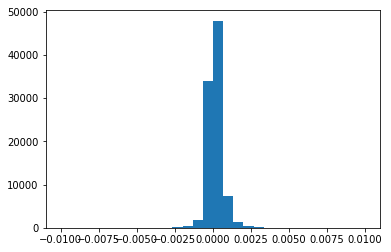

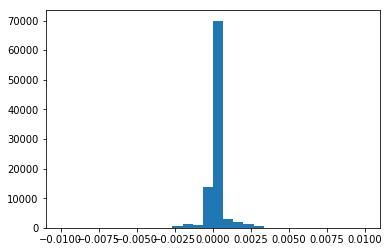

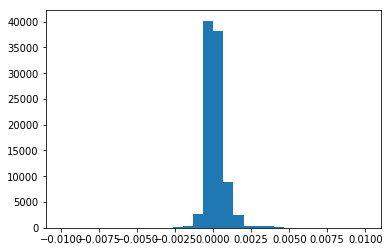

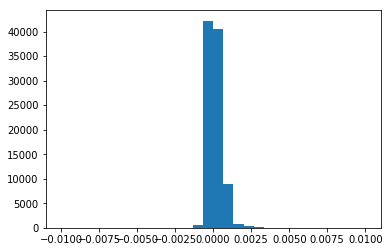

In [435]:
for i in [NN_test_pred,RE1_test_pred,RE2_test_pred,GBM_test_pred,RF1_test_pred,RF2_test_pred]:
    plt.hist(i,range=(-0.01,0.01),bins=30)
    plt.show()

### Light GBM

In [108]:
import lightgbm

In [109]:
bb=aa//4*3
Xlight_train=X_train[:bb]
Xlight_cv=X_train[bb:]
ylight_train=y_train[:bb]
ylight_cv=y_train[bb:]

light_train = lightgbm.Dataset(Xlight_train, label= ylight_train) 
light_cv = lightgbm.Dataset(Xlight_cv, label=ylight_cv) 

parameters = {
            'application':'regression',
            'metric': 'l2',
            'boosting': 'rf',
            'num_leaves': 10,     
            'min_data' : 200,
            'feature_fraction': 0.5,  
            'bagging_fraction': 0.3,
            'bagging_freq': 20,
            'learning_rate': 0.1,
            'max_depth': 4,
        }

model = lightgbm.train(parameters,
                       light_train,
                       valid_sets=light_cv,
                       num_boost_round=5000,
                       early_stopping_rounds=1000)


LGBM_train_pred = model.predict(X_train)
LGBM_test_pred = model.predict(X_test)

[1]	valid_0's l2: 0.000272607
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's l2: 0.000272298
[3]	valid_0's l2: 0.000272104
[4]	valid_0's l2: 0.00027217
[5]	valid_0's l2: 0.000272006
[6]	valid_0's l2: 0.000272033
[7]	valid_0's l2: 0.000271907
[8]	valid_0's l2: 0.000271869
[9]	valid_0's l2: 0.00027183
[10]	valid_0's l2: 0.00027181
[11]	valid_0's l2: 0.000271797
[12]	valid_0's l2: 0.00027181
[13]	valid_0's l2: 0.000271804
[14]	valid_0's l2: 0.000271818
[15]	valid_0's l2: 0.000271836
[16]	valid_0's l2: 0.0002718
[17]	valid_0's l2: 0.000271814
[18]	valid_0's l2: 0.000271811
[19]	valid_0's l2: 0.000271774
[20]	valid_0's l2: 0.00027179
[21]	valid_0's l2: 0.000271771
[22]	valid_0's l2: 0.000271749
[23]	valid_0's l2: 0.000271723
[24]	valid_0's l2: 0.000271719
[25]	valid_0's l2: 0.000271691
[26]	valid_0's l2: 0.000271689
[27]	valid_0's l2: 0.000271681
[28]	valid_0's l2: 0.000271674
[29]	valid_0's l2: 0.000271684
[30]	valid_0's l2: 0.000271689
[31]	valid_0's l2: 0.0

[310]	valid_0's l2: 0.000271456
[311]	valid_0's l2: 0.000271455
[312]	valid_0's l2: 0.000271454
[313]	valid_0's l2: 0.000271452
[314]	valid_0's l2: 0.00027145
[315]	valid_0's l2: 0.00027145
[316]	valid_0's l2: 0.000271447
[317]	valid_0's l2: 0.000271448
[318]	valid_0's l2: 0.000271447
[319]	valid_0's l2: 0.000271447
[320]	valid_0's l2: 0.000271445
[321]	valid_0's l2: 0.000271444
[322]	valid_0's l2: 0.000271445
[323]	valid_0's l2: 0.000271446
[324]	valid_0's l2: 0.000271446
[325]	valid_0's l2: 0.000271446
[326]	valid_0's l2: 0.000271447
[327]	valid_0's l2: 0.000271448
[328]	valid_0's l2: 0.000271449
[329]	valid_0's l2: 0.000271449
[330]	valid_0's l2: 0.00027145
[331]	valid_0's l2: 0.00027145
[332]	valid_0's l2: 0.000271451
[333]	valid_0's l2: 0.000271451
[334]	valid_0's l2: 0.000271452
[335]	valid_0's l2: 0.000271452
[336]	valid_0's l2: 0.000271452
[337]	valid_0's l2: 0.000271452
[338]	valid_0's l2: 0.000271453
[339]	valid_0's l2: 0.000271453
[340]	valid_0's l2: 0.000271453
[341]	valid_

[608]	valid_0's l2: 0.000271451
[609]	valid_0's l2: 0.000271452
[610]	valid_0's l2: 0.000271452
[611]	valid_0's l2: 0.000271452
[612]	valid_0's l2: 0.000271453
[613]	valid_0's l2: 0.000271453
[614]	valid_0's l2: 0.000271454
[615]	valid_0's l2: 0.000271454
[616]	valid_0's l2: 0.000271454
[617]	valid_0's l2: 0.000271454
[618]	valid_0's l2: 0.000271454
[619]	valid_0's l2: 0.000271454
[620]	valid_0's l2: 0.000271455
[621]	valid_0's l2: 0.000271454
[622]	valid_0's l2: 0.000271453
[623]	valid_0's l2: 0.000271453
[624]	valid_0's l2: 0.000271452
[625]	valid_0's l2: 0.000271452
[626]	valid_0's l2: 0.000271452
[627]	valid_0's l2: 0.000271452
[628]	valid_0's l2: 0.000271451
[629]	valid_0's l2: 0.000271451
[630]	valid_0's l2: 0.000271451
[631]	valid_0's l2: 0.00027145
[632]	valid_0's l2: 0.000271451
[633]	valid_0's l2: 0.000271451
[634]	valid_0's l2: 0.000271451
[635]	valid_0's l2: 0.000271451
[636]	valid_0's l2: 0.000271451
[637]	valid_0's l2: 0.00027145
[638]	valid_0's l2: 0.00027145
[639]	valid

[867]	valid_0's l2: 0.000271475
[868]	valid_0's l2: 0.000271475
[869]	valid_0's l2: 0.000271475
[870]	valid_0's l2: 0.000271475
[871]	valid_0's l2: 0.000271474
[872]	valid_0's l2: 0.000271475
[873]	valid_0's l2: 0.000271475
[874]	valid_0's l2: 0.000271475
[875]	valid_0's l2: 0.000271475
[876]	valid_0's l2: 0.000271475
[877]	valid_0's l2: 0.000271475
[878]	valid_0's l2: 0.000271475
[879]	valid_0's l2: 0.000271475
[880]	valid_0's l2: 0.000271475
[881]	valid_0's l2: 0.000271475
[882]	valid_0's l2: 0.000271475
[883]	valid_0's l2: 0.000271476
[884]	valid_0's l2: 0.000271476
[885]	valid_0's l2: 0.000271476
[886]	valid_0's l2: 0.000271476
[887]	valid_0's l2: 0.000271476
[888]	valid_0's l2: 0.000271476
[889]	valid_0's l2: 0.000271477
[890]	valid_0's l2: 0.000271477
[891]	valid_0's l2: 0.000271477
[892]	valid_0's l2: 0.000271477
[893]	valid_0's l2: 0.000271478
[894]	valid_0's l2: 0.000271478
[895]	valid_0's l2: 0.000271478
[896]	valid_0's l2: 0.000271478
[897]	valid_0's l2: 0.000271479
[898]	va

[1130]	valid_0's l2: 0.00027147
[1131]	valid_0's l2: 0.000271471
[1132]	valid_0's l2: 0.00027147
[1133]	valid_0's l2: 0.00027147
[1134]	valid_0's l2: 0.000271471
[1135]	valid_0's l2: 0.000271471
[1136]	valid_0's l2: 0.000271471
[1137]	valid_0's l2: 0.000271471
[1138]	valid_0's l2: 0.000271471
[1139]	valid_0's l2: 0.000271471
[1140]	valid_0's l2: 0.000271471
[1141]	valid_0's l2: 0.000271471
[1142]	valid_0's l2: 0.000271471
[1143]	valid_0's l2: 0.000271471
[1144]	valid_0's l2: 0.000271471
[1145]	valid_0's l2: 0.000271471
[1146]	valid_0's l2: 0.000271471
[1147]	valid_0's l2: 0.000271471
[1148]	valid_0's l2: 0.000271471
[1149]	valid_0's l2: 0.000271471
[1150]	valid_0's l2: 0.000271471
[1151]	valid_0's l2: 0.000271471
[1152]	valid_0's l2: 0.000271471
[1153]	valid_0's l2: 0.000271471
[1154]	valid_0's l2: 0.000271471
[1155]	valid_0's l2: 0.000271471
[1156]	valid_0's l2: 0.000271472
[1157]	valid_0's l2: 0.000271471
[1158]	valid_0's l2: 0.000271471
[1159]	valid_0's l2: 0.000271471
[1160]	valid_

[1379]	valid_0's l2: 0.000271468
[1380]	valid_0's l2: 0.000271468
[1381]	valid_0's l2: 0.000271468
[1382]	valid_0's l2: 0.000271468
[1383]	valid_0's l2: 0.000271468
[1384]	valid_0's l2: 0.000271467
[1385]	valid_0's l2: 0.000271467
[1386]	valid_0's l2: 0.000271467
[1387]	valid_0's l2: 0.000271467
[1388]	valid_0's l2: 0.000271466
[1389]	valid_0's l2: 0.000271466
[1390]	valid_0's l2: 0.000271466
[1391]	valid_0's l2: 0.000271466
[1392]	valid_0's l2: 0.000271466
[1393]	valid_0's l2: 0.000271466
[1394]	valid_0's l2: 0.000271466
[1395]	valid_0's l2: 0.000271465
[1396]	valid_0's l2: 0.000271465
[1397]	valid_0's l2: 0.000271465
[1398]	valid_0's l2: 0.000271465
[1399]	valid_0's l2: 0.000271465
[1400]	valid_0's l2: 0.000271465
[1401]	valid_0's l2: 0.000271464
[1402]	valid_0's l2: 0.000271465
[1403]	valid_0's l2: 0.000271464
[1404]	valid_0's l2: 0.000271464
[1405]	valid_0's l2: 0.000271464
[1406]	valid_0's l2: 0.000271464
[1407]	valid_0's l2: 0.000271464
[1408]	valid_0's l2: 0.000271464
[1409]	val

In [110]:
print('in sample R2:', r2_score(y_train,LGBM_train_pred))
print('out sample R2:',r2_score(y_test,LGBM_test_pred))
dd.append([r2_score(y_train,LGBM_train_pred),r2_score(y_test,LGBM_test_pred)])

in sample R2: 0.003397944031170552
out sample R2: 0.0007119331411737928


In [111]:
result=pd.DataFrame(data=dd,columns=['train','test'],index=['NN','GBM','Regression1','Regression2','Forest1','Forest2','AGG_NN',
                                                          'AGG_OLS','AGG_Las','AGG_Rid','AGG_Forest','AGG_LGBM'])

In [112]:
result

,train,test
NN,0.001097,0.001088
GBM,0.000342,0.001105
Regression1,0.000995,0.001214
Regression2,0.001059,0.000960
Forest1,0.001440,0.001207
Forest2,0.000953,0.001166
AGG_NN,-0.000002,-0.000038
AGG_OLS,0.001893,0.000672
AGG_Las,0.001555,0.001332
AGG_Rid,0.001586,0.001304


In [510]:
data_nona=data_test[-23429:]
data_nona.head()

,Date,sec_id,fut_ret,vol,X1,X3,X4,X6,X7,X1_norm,X3_norm,X4_norm,X6_norm,X7_norm,log_vol,ret_vol
374248,0.939698,0.875942,-0.002807,0.000623,0.004076,0.0,0.0,0.0,0.0,3.266190,0.095161,-0.109858,0.180895,-0.080587,0.438843,-4.506538
374249,0.939698,0.876444,-0.016596,0.000702,-0.002402,0.0,0.0,0.0,0.0,-2.359605,0.095161,-0.109858,0.180895,-0.080587,0.643375,-23.628550
374250,0.939698,0.876946,0.003351,0.000898,0.002189,0.0,0.0,0.0,0.0,1.628010,0.095161,-0.109858,0.180895,-0.080587,1.071969,3.729887
374251,0.939698,0.877449,-0.008604,0.000597,0.000000,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180895,-0.080587,0.366320,-14.421489
374252,0.939698,0.877951,0.025364,0.000537,-0.001434,0.0,0.0,0.0,0.0,-1.518775,0.095161,-0.109858,0.180895,-0.080587,0.192295,47.193310


In [513]:
data_nona['prediction']=ranf.predict(X_test)

/home/zecophy/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [515]:
data_raw=pd.read_csv("trimmed_data_v3.csv",index_col=0)
data_raw2=data_raw[np.isnan(data_raw.vol)]
data_na=data_raw2.loc[374248:]
data_na.head()

,Date,sec_id,fut_ret,vol,X1,X3,X4,X6,X7,X1_norm,X3_norm,X4_norm,X6_norm,X7_norm,log_vol
374351,0.939698,0.927675,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180895,-0.080587,-3.438812
374357,0.939698,0.930688,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180895,-0.080587,-3.438812
374365,0.939698,0.934706,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180895,-0.080587,-3.438812
374386,0.939698,0.945254,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180895,-0.080587,-3.438812
374400,0.939698,0.952285,0.0,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180895,-0.080587,-3.438812


In [517]:
X_train = data_raw2.loc[:374248][['sec_id', 'X1_norm', 'X3_norm', 'X4_norm', 'X6_norm', 'X7_norm']]
y_train = data_raw2.loc[:374248]['fut_ret']

linReg = LinearRegression().fit(X_train, y_train)

X_test=data_na[['sec_id', 'X1_norm', 'X3_norm', 'X4_norm', 'X6_norm', 'X7_norm']]

In [518]:
data_na['prediction']=linReg.predict(X_test)

/home/zecophy/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [519]:
data_nnn=pd.concat([data_nona,data_na])
data_nnn.sort_index()
data_nnn.head()

/home/zecophy/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Date,X1,X1_norm,X3,X3_norm,X4,X4_norm,X6,X6_norm,X7,X7_norm,fut_ret,log_vol,prediction,ret_vol,sec_id,vol
374248,0.939698,0.004076,3.266190,0.0,0.095161,0.0,-0.109858,0.0,0.180895,0.0,-0.080587,-0.002807,0.438843,0.000959,-4.506538,0.875942,0.000623
374249,0.939698,-0.002402,-2.359605,0.0,0.095161,0.0,-0.109858,0.0,0.180895,0.0,-0.080587,-0.016596,0.643375,-0.000631,-23.628550,0.876444,0.000702
374250,0.939698,0.002189,1.628010,0.0,0.095161,0.0,-0.109858,0.0,0.180895,0.0,-0.080587,0.003351,1.071969,0.000348,3.729887,0.876946,0.000898
374251,0.939698,0.000000,-0.273594,0.0,0.095161,0.0,-0.109858,0.0,0.180895,0.0,-0.080587,-0.008604,0.366320,0.000285,-14.421489,0.877449,0.000597
374252,0.939698,-0.001434,-1.518775,0.0,0.095161,0.0,-0.109858,0.0,0.180895,0.0,-0.080587,0.025364,0.192295,0.000181,47.193310,0.877951,0.000537


In [520]:
r2_score(data_nnn['fut_ret'],data_nnn['prediction'])

0.0022341286841131014

### test fill 0 at na

In [488]:
data_raw=pd.read_csv("trimmed_data_v3.csv",index_col=0)
data_raw2=data_raw[np.isnan(data_raw.vol)]
data_raw1=data_raw[~np.isnan(data_raw.vol)]
print(sum(np.isnan(data_raw.vol)),len(data_raw2))

20887 20887


In [489]:
data_new=data.iloc[277938:]
data_new['prediction']=ranf.predict(np.concatenate((X_train,X_test),axis=0))

ValueError: Length of values does not match length of index

In [482]:
data_new.head()

,Date,sec_id,fut_ret,vol,X1,X3,X4,X6,X7,X1_norm,X3_norm,X4_norm,X6_norm,X7_norm,log_vol,ret_vol,prediction
300792,0.758794,0.000000,0.007288,0.000514,-0.000410,0.0,0.0,-0.000073,0.000000e+00,-0.629850,0.095161,-0.109858,-0.180296,-0.080587,0.118069,14.186268,0.000214
300793,0.758794,0.000502,0.035414,0.000711,0.000000,0.0,0.0,0.000000,0.000000e+00,-0.273594,0.095161,-0.109858,0.180895,-0.080587,0.663143,49.844115,0.000244
300794,0.758794,0.001005,-0.004633,0.000423,-0.000139,0.0,0.0,-0.000013,0.000000e+00,-0.394243,0.095161,-0.109858,0.115592,-0.080587,-0.193753,-10.939116,0.000214
300795,0.758794,0.001507,-0.005127,0.000328,0.000118,0.0,0.0,-0.000007,1.496831e-11,-0.171473,0.095161,-0.109858,0.148545,-0.080586,-0.587305,-15.617786,0.000214
300796,0.758794,0.002009,-0.005884,0.000370,-0.000357,0.0,0.0,0.000000,0.000000e+00,-0.583750,0.095161,-0.109858,0.180895,-0.080587,-0.405266,-15.905716,0.000214


In [484]:
data=pd.read_csv("trimmed_data_v3.csv",index_col=0)
data=data[np.isnan(data.vol)]

X_train = data.loc[:][['sec_id', 'X1_norm', 'X3_norm', 'X4_norm', 'X6_norm', 'X7_norm']]
y_train = data.loc[:]['fut_ret']

linReg = LinearRegression().fit(X_train, y_train)
print('Linear regression in sample R2:', linReg.score(X_train, y_train))
print('Coefficients:', linReg.coef_)


data_new2=data_raw2.loc[300792:]
X_test = data_new2[['sec_id', 'X1_norm', 'X3_norm', 'X4_norm', 'X6_norm', 'X7_norm']]
y_test = data_new2['fut_ret']

data_new2['prediction']=linReg(X_test)
data_new2.head()

ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required.

In [198]:
data_new3=pd.concat([data_new,data_new2])
data_new3.sort_index()
data_new3.head()

/home/zecophy/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Date,X1,X1_norm,X3,X3_norm,X4,X4_norm,X6,X6_norm,X7,X7_norm,fut_ret,log_vol,prediction,ret_vol,sec_id,vol
300792,0.758794,-0.000410,-0.629850,0.0,0.095161,0.0,-0.109858,-0.000073,-0.180296,0.000000e+00,-0.080587,0.007288,0.118069,0.000214,14.186268,0.000000,0.000514
300793,0.758794,0.000000,-0.273594,0.0,0.095161,0.0,-0.109858,0.000000,0.180895,0.000000e+00,-0.080587,0.035414,0.663143,0.000244,49.844115,0.000502,0.000711
300794,0.758794,-0.000139,-0.394243,0.0,0.095161,0.0,-0.109858,-0.000013,0.115592,0.000000e+00,-0.080587,-0.004633,-0.193753,0.000214,-10.939116,0.001005,0.000423
300795,0.758794,0.000118,-0.171473,0.0,0.095161,0.0,-0.109858,-0.000007,0.148545,1.496831e-11,-0.080586,-0.005127,-0.587305,0.000214,-15.617786,0.001507,0.000328
300796,0.758794,-0.000357,-0.583750,0.0,0.095161,0.0,-0.109858,0.000000,0.180895,0.000000e+00,-0.080587,-0.005884,-0.405266,0.000214,-15.905716,0.002009,0.000370


In [206]:
p1=data_new3.loc[374248:].prediction
p2=data_new3.loc[374248:].fut_ret
print(len(p1))
r2_score(p2,p1)

25734


0.002196007253825405

In [205]:
p1=data_new3.loc[374248:].dropna().prediction
p2=data_new3.loc[374248:].dropna().fut_ret
print(len(p1))
r2_score(p2,p1)

23429


0.002200795285091872

In [207]:
(25734-23429)/25734

0.08957021838812466

In [ ]:
p1=yyyy[-25734:]
p2=data_new3.loc[374248:].fut_ret
r2_score(p2,p1)

## Final Algorithm

In [ ]:
ranf.predict()

## Put Together

In [464]:
data=pd.read_csv("trimmed_data_v3.csv",index_col=0)
data=data[np.isnan(data.vol)]

X_train = data[['sec_id', 'X1_norm', 'X3_norm', 'X4_norm', 'X6_norm', 'X7_norm']]
y_train = data['fut_ret']


linReg = LinearRegression().fit(X_train, y_train)
print('Linear regression in sample R2:', linReg.score(X_train, y_train))
print('Coefficients:', linReg.coef_)

Linear regression in sample R2: 0.0005359847256536376
Coefficients: [ 4.66862276e-05 -1.03741538e-03  3.72330576e-04  1.48932230e-03
 -1.48932230e-03  3.72330576e-04]


In [465]:
X_test=data_2[['sec_id', 'X1_norm', 'X3_norm', 'X4_norm', 'X6_norm', 'X7_norm']]

In [466]:
data_2['prediction']=linReg.predict(X_test)

In [467]:
data_2

,Date,sec_id,vol,X1,X3,X4,X6,X7,X1_norm,X3_norm,X4_norm,X6_norm,X7_norm,log_vol,prediction
53,0.796813,0.026620,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180894,-0.080588,-3.438812,-0.000069
68,0.796813,0.034154,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180894,-0.080588,-3.438812,-0.000069
71,0.796813,0.035660,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180894,-0.080588,-3.438812,-0.000069
82,0.796813,0.041185,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180894,-0.080588,-3.438812,-0.000068
92,0.796813,0.046208,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180894,-0.080588,-3.438812,-0.000068
112,0.796813,0.056253,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180894,-0.080588,-3.438812,-0.000068
131,0.796813,0.065796,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180894,-0.080588,-3.438812,-0.000067
156,0.796813,0.078353,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180894,-0.080588,-3.438812,-0.000067
169,0.796813,0.084882,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180894,-0.080588,-3.438812,-0.000066
190,0.796813,0.095429,NaN,0.0,0.0,0.0,0.0,0.0,-0.273594,0.095161,-0.109858,0.180894,-0.080588,-3.438812,-0.000066


In [468]:
data_1.head()

,Date,sec_id,vol,X1,X3,X4,X6,X7,X1_norm,X3_norm,X4_norm,X6_norm,X7_norm,log_vol,prediction
0,0.796813,0.000000,0.000555,-0.000193,0.0,0.0,-0.000489,0.0,-0.441311,0.095161,-0.109858,-2.226096,-0.080588,0.244330,0.000140
1,0.796813,0.000502,0.000781,0.000000,0.0,0.0,0.000000,0.0,-0.273594,0.095161,-0.109858,0.180894,-0.080588,0.826483,0.000268
2,0.796813,0.001005,0.000393,0.000265,0.0,0.0,0.000000,0.0,-0.043271,0.095161,-0.109858,0.180894,-0.080588,-0.311499,0.000140
3,0.796813,0.001507,0.000289,0.000310,0.0,0.0,0.000000,0.0,-0.003970,0.095161,-0.109858,0.180894,-0.080588,-0.776211,0.000140
4,0.796813,0.002009,0.000343,0.000300,0.0,0.0,0.000000,0.0,-0.013108,0.095161,-0.109858,0.180894,-0.080588,-0.521118,0.000140


In [469]:
data_final=pd.concat([data_1,data_2])
data_final=data_final.sort_index()
data_final

,Date,sec_id,vol,X1,X3,X4,X6,X7,X1_norm,X3_norm,X4_norm,X6_norm,X7_norm,log_vol,prediction
0,0.796813,0.000000,0.000555,-0.000193,0.000000,0.000000,-0.000489,0.000000,-0.441311,0.095161,-0.109858,-2.226096,-0.080588,0.244330,0.000140
1,0.796813,0.000502,0.000781,0.000000,0.000000,0.000000,0.000000,0.000000,-0.273594,0.095161,-0.109858,0.180894,-0.080588,0.826483,0.000268
2,0.796813,0.001005,0.000393,0.000265,0.000000,0.000000,0.000000,0.000000,-0.043271,0.095161,-0.109858,0.180894,-0.080588,-0.311499,0.000140
3,0.796813,0.001507,0.000289,0.000310,0.000000,0.000000,0.000000,0.000000,-0.003970,0.095161,-0.109858,0.180894,-0.080588,-0.776211,0.000140
4,0.796813,0.002009,0.000343,0.000300,0.000000,0.000000,0.000000,0.000000,-0.013108,0.095161,-0.109858,0.180894,-0.080588,-0.521118,0.000140
5,0.796813,0.002511,0.000606,0.000749,0.000000,0.000000,0.000000,0.000000,0.377339,0.095161,-0.109858,0.180894,-0.080588,0.393461,0.000140
7,0.796813,0.003516,0.000314,-0.000062,0.000000,0.000000,0.000000,0.000000,-0.327756,0.095161,-0.109858,0.180894,-0.080588,-0.651707,0.000140
8,0.796813,0.004018,0.000546,0.001577,0.000000,0.000000,0.000000,0.000000,1.096038,0.095161,-0.109858,0.180894,-0.080588,0.218203,0.000185
9,0.796813,0.004520,0.000360,-0.001620,0.000000,0.000000,0.000000,0.000064,-1.680802,0.095161,-0.109858,0.180894,3.727445,-0.445247,0.000102
10,0.796813,0.005023,0.000366,0.000632,0.000000,0.000000,0.000000,0.000000,0.275357,0.095161,-0.109858,0.180894,-0.080588,-0.421733,0.000140


In [535]:
data_final=data_final.sort_index()
data_final

,Date,sec_id,vol,X1,X3,X4,X6,X7,X1_norm,X3_norm,X4_norm,X6_norm,X7_norm,log_vol,prediction
0,0.796813,0.000000,0.000555,-0.000193,0.000000,0.000000,-4.893806e-04,0.000000,-0.441311,0.095161,-0.109858,-2.226096,-0.080588,0.244330,0.000140
1,0.796813,0.000502,0.000781,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.273594,0.095161,-0.109858,0.180894,-0.080588,0.826483,0.000268
2,0.796813,0.001005,0.000393,0.000265,0.000000,0.000000,0.000000e+00,0.000000,-0.043271,0.095161,-0.109858,0.180894,-0.080588,-0.311499,0.000140
3,0.796813,0.001507,0.000289,0.000310,0.000000,0.000000,0.000000e+00,0.000000,-0.003970,0.095161,-0.109858,0.180894,-0.080588,-0.776211,0.000140
4,0.796813,0.002009,0.000343,0.000300,0.000000,0.000000,0.000000e+00,0.000000,-0.013108,0.095161,-0.109858,0.180894,-0.080588,-0.521118,0.000140
5,0.796813,0.002511,0.000606,0.000749,0.000000,0.000000,0.000000e+00,0.000000,0.377339,0.095161,-0.109858,0.180894,-0.080588,0.393461,0.000140
7,0.796813,0.003516,0.000314,-0.000062,0.000000,0.000000,0.000000e+00,0.000000,-0.327756,0.095161,-0.109858,0.180894,-0.080588,-0.651707,0.000140
8,0.796813,0.004018,0.000546,0.001577,0.000000,0.000000,0.000000e+00,0.000000,1.096038,0.095161,-0.109858,0.180894,-0.080588,0.218203,0.000185
9,0.796813,0.004520,0.000360,-0.001620,0.000000,0.000000,0.000000e+00,0.000064,-1.680802,0.095161,-0.109858,0.180894,3.727445,-0.445247,0.000102
10,0.796813,0.005023,0.000366,0.000632,0.000000,0.000000,0.000000e+00,0.000000,0.275357,0.095161,-0.109858,0.180894,-0.080588,-0.421733,0.000140


In [470]:
len(data_final)

101643

In [536]:
res=np.array(data_final.prediction)

with open('oos_prediction_v3', 'wb') as fp:
    pickle.dump(res, fp)

In [538]:
with open ('oos_prediction', 'rb') as fp:
    p1 = pickle.load(fp)

with open ('oos_prediction_v2', 'rb') as fp:
    p2 = pickle.load(fp)

with open ('oos_prediction_v3', 'rb') as fp:
    p3 = pickle.load(fp)
    
np.corrcoef(p2,p3)[0,1]

0.0011050440761399586

In [539]:
p3

array([0.00013978, 0.00026821, 0.00013978, ..., 0.00158668, 0.00019774,
       0.00019774])

In [473]:
p1

array([0.0001098 , 0.0001098 , 0.0001098 , ..., 0.0001098 , 0.00134941,
       0.0001098 ])

In [474]:
p2

array([ 1.39781304e-04,  2.68207851e-04,  1.39781304e-04, ...,
       -2.43197042e-05, -2.40383206e-05, -2.39210774e-05])

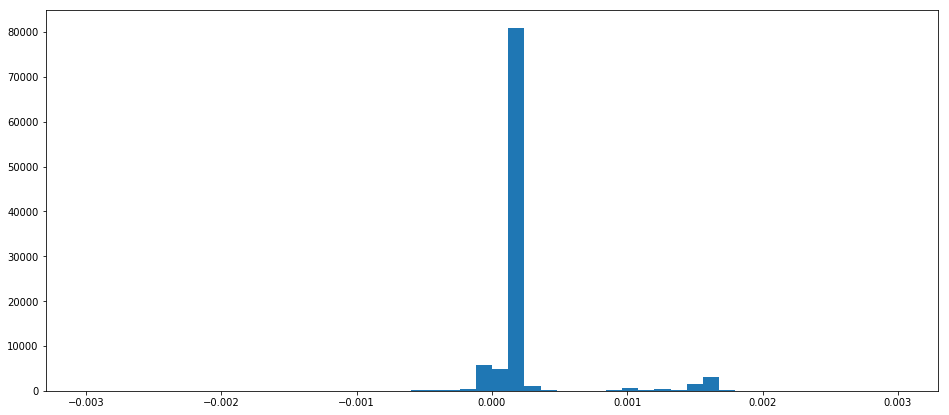

In [540]:
plt.figure(figsize=(16,7))
plt.hist(p3,range=(-0.003,0.003),bins=50)
plt.show()

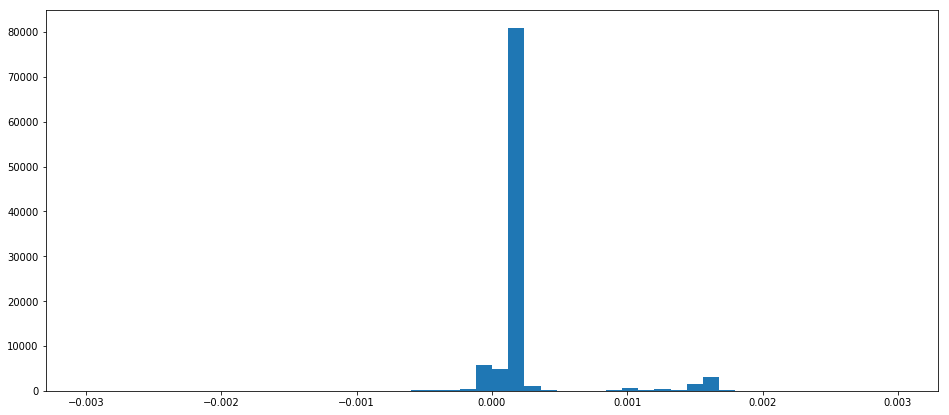

In [480]:
plt.figure(figsize=(16,7))
plt.hist(p2,range=(-0.003,0.003),bins=50)
plt.show()

In [541]:
with open ('oos_prediction_v3', 'rb') as fp:
    p3 = pickle.load(fp)
    
p3

array([0.00013978, 0.00026821, 0.00013978, ..., 0.00158668, 0.00019774,
       0.00019774])

In [543]:
final_res = pd.DataFrame(p3, index=data_laoshi.index, columns = ['fut_ret_predict'])
final_res['Date'] = data_laoshi['Date']
final_res['sec_id'] = data_laoshi['sec_id']

In [544]:
final_res.to_csv("oos_prediction_Lexington_Alpha_2.csv",index=False)

In [531]:
data_laoshi=pd.read_csv("dat_final_oos_noy.csv")
data_laoshi

TypeError: parser_f() got an unexpected keyword argument 'index'

In [545]:
final_res

,fut_ret_predict,Date,sec_id
0,0.000140,200,0
1,0.000268,200,1
2,0.000140,200,2
3,0.000140,200,3
4,0.000140,200,4
5,0.000140,200,5
6,0.000140,200,7
7,0.000185,200,8
8,0.000102,200,9
9,0.000140,200,10


In [546]:
np.corrcoef(p2,p3)

array([[1.        , 0.00110504],
       [0.00110504, 1.        ]])

In [547]:
np.corrcoef(p1,p3)

array([[1.        , 0.78580185],
       [0.78580185, 1.        ]])